# Introduction

In [1]:
import pyspark
from pyspark.sql import SparkSession, functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
conf = pyspark.SparkConf()
settings = conf.getAll()

# Current Spark settings
for s in settings:
    print(s)
executor_memory = conf.get("spark.executor.memory")
executor_cores = conf.get("spark.executor.cores")
default_parallelism = conf.get("spark.default.parallelism")

# Set Spark Settings
conf = pyspark.SparkConf().setAll([
('spark.master', 'local[*]'),
('spark.app.name', 'MusicRecommender')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [61]:
# Config Variables
user = "hadoop"
HDFS_DATA = f"hdfs:///user/{user}/data"
partitions = 10

In [83]:
def load_file_from_hdfs(file_name):
    hdfs_path = f"{HDFS_DATA}/{file_name}"
    return spark.read.csv(hdfs_path, sep="\t", header=False, inferSchema=True).cache()


train_files = [f"train/train_{i}.txt" for i in range(partitions)]
test_files = [f"test/test_{i}.txt" for i in range(partitions)]

train_data = []
test_data = []

for file in train_files:
    train_partition_df = load_file_from_hdfs(file)
    train_partition_df = train_partition_df.withColumnsRenamed({"_c0": "user_id", "_c1": "song_id", "_c2": "rating"})
    train_data.append(train_partition_df)
    
for file in test_files:
    test_partition_df = load_file_from_hdfs(file)
    test_partition_df = test_partition_df.withColumnsRenamed({"_c0": "user_id", "_c1": "song_id", "_c2": "rating"})
    test_data.append(test_partition_df)

In [105]:
def perform_eda(df):
    df.summary().show()
    
    users = df.groupBy("user_id").count()
    print("Number of unique users: ", len(users.collect()))

    songs = df.groupBy("song_id").count()
    print("Number of unique songs: ", len(songs.collect()))
    
    ratings = df.count()
    print("Number of ratings: ", ratings)
    
    # Distribution of ratings per user
    user_rating_counts_statistics = users.select("count").describe().toPandas()
    print(f"Ratings per user distribution: \n{user_rating_counts_statistics}")    
    user_rating_counts = users.select("count").rdd.flatMap(lambda x: x).collect()
    
    # plot violin plot
    sns.violinplot(data=user_rating_counts)
    plt.title('Ratings per User')

    # Show the plot
    plt.show()
    
    return df

def plot_user_ratings_distribution(df, ax, partition_id):
    user_rating_counts = df.groupBy("user_id").count()
    user_rating_counts = user_rating_counts.withColumnRenamed("count", "rating_count")
    user_rating_counts = user_rating_counts.groupBy("rating_count").count()
    user_rating_counts = user_rating_counts.withColumnRenamed("count", "user_count")
    user_rating_counts = user_rating_counts.sort("rating_count").toPandas()
    # min_rating = user_rating_counts['rating_count'].min()
    # max_rating = user_rating_counts['rating_count'].max()

    
    # plot a violin plot
    # sns.violinplot(data=user_rating_counts['rating_count'], ax=ax)
    # ax.set_title(f'User Ratings Distribution - Partition {partition_id}')
    # ax.set_xlabel('Users')
    # ax.set_ylabel('Number of Ratings')
    # ax.set_ylim(0, 135000)
    
    # plot a bar
    sns.barplot(x='rating_count', y='user_count', data=user_rating_counts, ax=ax)
    ax.set_title(f'User Ratings Distribution - Partition {partition_id}')
    ax.set_xlabel('Number of Ratings')
    ax.set_ylabel('Number of Users')
    ax.set_ylim(0, 135000)
    


# Training

In [106]:
# Show the first 5 rows of the train data
train_data[0].show(5)

+-------+-------+------+
|user_id|song_id|rating|
+-------+-------+------+
|      0|    166|     5|
|      0|   2245|     4|
|      0|   3637|     4|
|      0|   5580|     4|
|      0|   5859|     4|
+-------+-------+------+
only showing top 5 rows



Processing train data partition 0
Processing train data partition 1


Processing train data partition 2


Processing train data partition 3


Processing train data partition 4


Processing train data partition 5


Processing train data partition 6


Processing train data partition 7


Processing train data partition 8


Processing train data partition 9


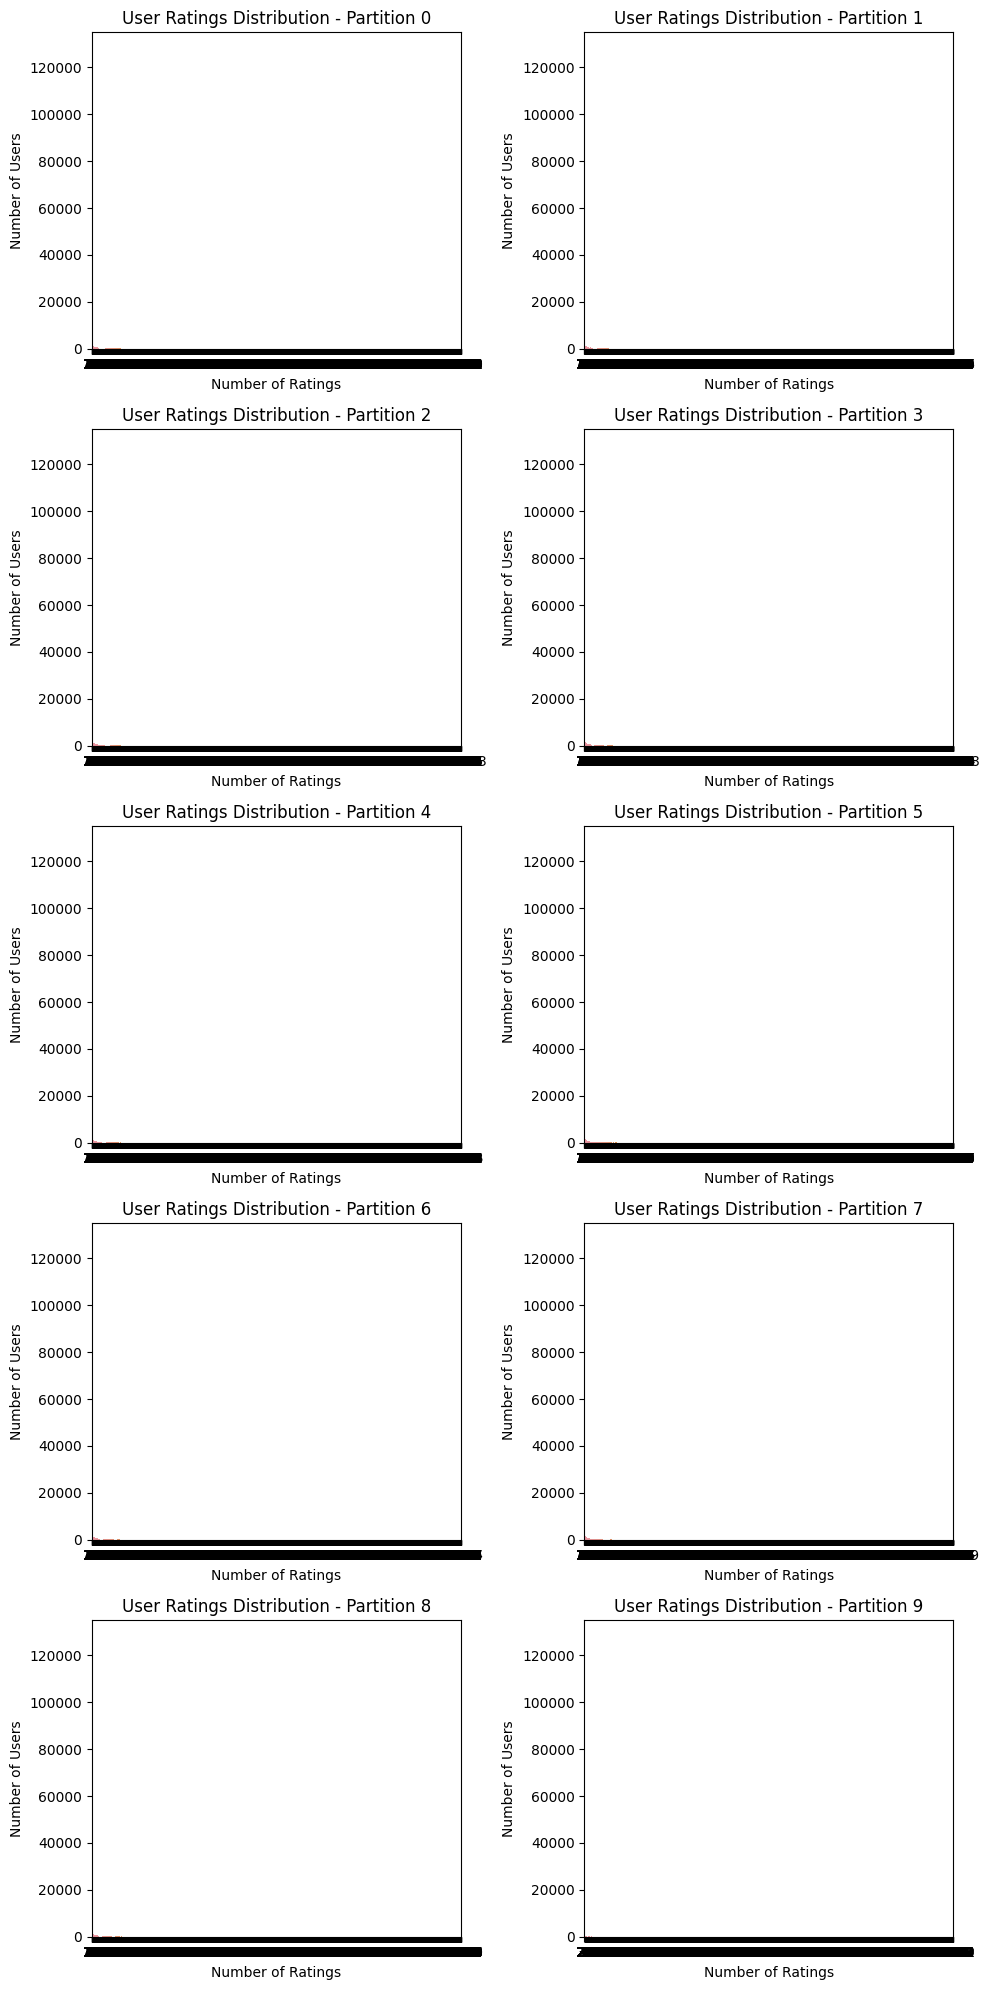

In [107]:
fig, ax = plt.subplots(nrows=5,ncols=2, figsize=(10, 20))
for i in range(len(train_data)):
    row = i // 2
    col = i % 2
    print(f"Processing train data partition {i}")
    plot_user_ratings_distribution(train_data[i], ax=ax[row, col], partition_id=i)
plt.tight_layout()
plt.show()

# Test

In [ ]:
# for i in range(len(test_data)):
#     print(f"Processing test data partition {i}")
#     test_data[i] = perform_data_preprocessing(test_data[i])
#     # perform_eda(test_data[i])

In [ ]:
spark.stop()